In [22]:
### Python2.7
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import seaborn as sns
import pylab as pl
from sklearn.tree import export_graphviz

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h1>Смысловое описание признаков</h1>

- Температура (T) от 1.81°C до 37.11°C
- Атмосферное давление (AP) от 992.89 до 1033.30 милибар
- Относительная влажность (RH) от 25.56% до 100.16%
- Вакуум на выхлопе паровой трубы (V) от 25.36 до 81.56 см. рт. ст. ( [ссылка на перевод]( https://www.multitran.com/m.exe?l1=1&l2=2&s=exhaust%20vacuum) )
- Часовая выработка электроэнергии (EP) от 420.26 до 495.76 МегаВатт

# 1. Подготовка

## 1.1. Загрузка данных

In [15]:
data = pd.read_csv("./ccpp.csv", # путь к файлу, используй автодополнение
                   sep=';', # разделитель данных в файле
                   decimal=",",
                   header=0 # номер строки с заголовками. header='None', если заголовки отсутствуют
                  )

In [16]:
data.shape

(9568, 5)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [19]:
#Убедимся в отсутсвии пропусков
data.isnull().sum() 

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [23]:
# описание для всех столбцов
data.describe(include='all') 

,AT,V,AP,RH,PE
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,19.651,54.306,1013.259,73.309,454.365
std,7.452,12.708,5.939,14.600,17.067
min,1.810,25.360,992.890,25.560,420.260
25%,13.510,41.740,1009.100,63.328,439.750
50%,20.345,52.080,1012.940,74.975,451.550
75%,25.720,66.540,1017.260,84.830,468.430
max,37.110,81.560,1033.300,100.160,495.760


Переименуем колонки для удобства:

In [25]:
data.columns = ([u'Temperature', u'Vacuum', u'Pressure',u'Humidity', u'EnergyOutput'])

In [26]:
data.head()

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
0,8.340,40.770,1010.840,90.010,480.480
1,23.640,58.490,1011.400,74.200,445.750
2,29.740,56.900,1007.150,41.910,438.760
3,19.070,49.690,1007.220,76.790,453.090
4,11.800,40.660,1017.130,97.200,464.430


## 1.2. Разбиение на обучающую и тестовую выборку

В качестве целевого значения и независимых признаков выберем те же столбцы, что и в ЛР1

In [28]:
features = [u'Temperature', u'Vacuum',]
target = [u'EnergyOutput']

Проверим значения коэфф. парной корреляции для целевой переменной

In [30]:
data[features+target].corr()['EnergyOutput']

Temperature    -0.948
Vacuum         -0.870
EnergyOutput    1.000
Name: EnergyOutput, dtype: float64

Разделим выборку на обучающую (тренировочную, "train") и отложенная (проверочную, "test") части, методом train_test_split. В результате получим 4 объекта x_train, x_test, y_train, y_test.

In [32]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 6697, y_train 6697 
  x_test:  2871, y_test  2871 
  total x: 9568, total y 9568 


In [34]:
x_test.head(2)

,Temperature,Vacuum
8722,12.640,41.490
8479,27.080,62.910


In [37]:
y_test.head(2)

,EnergyOutput
8722,468.780
8479,442.910


# 2. Регрессионные модели

## 2.1. Множественная линейная

Построим модель множественной линейной регрессии от двух переменных Temperature, Vacuum

In [39]:
# создать модель
model_LinRegrMult = linear_model.LinearRegression()

# обучить модель на тренировочной части выборки
model_LinRegrMult.fit(x_train, y_train)

# получить предсказанные значения на проверочной части выборки
y_pred_LinRegrMult = model_LinRegrMult.predict(x_test)

In [40]:
print "Множественная линейная регрессия. Полный диапазон."
print "y_pred_lin_reg_mult (x1, x2) =\n   {:,.3f}*{:} + {:,.3f}*{:} + {:,.3f}\n".format(
    model_LinRegrMult.coef_[0][0], features[0],
    model_LinRegrMult.coef_[0][1], features[1],
    model_LinRegrMult.intercept_[0])

mae_LinRegrMult = metrics.mean_absolute_error(y_test, y_pred_LinRegrMult)
r2_LinRegrMult  = metrics.r2_score           (y_test, y_pred_LinRegrMult)

print "MAE - Cредняя абсолютная ошибка: {:>7,.0f}".format( mae_LinRegrMult )
print "R2 - коэфф. детерминации:        {:>7,.3f}".format       ( r2_LinRegrMult )

Множественная линейная регрессия. Полный диапазон.
y_pred_lin_reg_mult (x1, x2) =
   -1.696*Temperature + -0.328*Vacuum + 505.521

MAE - Cредняя абсолютная ошибка:       4
R2 - коэфф. детерминации:          0.918


Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

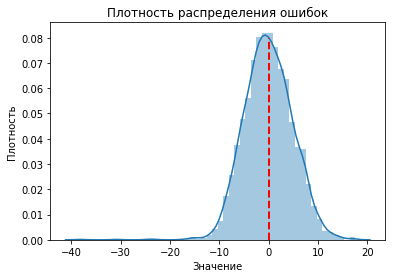

In [51]:
plt.figure(figsize=(6,4))
sns.distplot((y_test - y_pred_LinRegrMult))
plt.plot(
    [0, 0],
    [0, 8 * pow(10,-2)],
    '--', lw=2, label=u"границы диапазона", c='r')
plt.title(u'Плотность распределения ошибок');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

Text(0,0.5,u'\u041a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u043e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

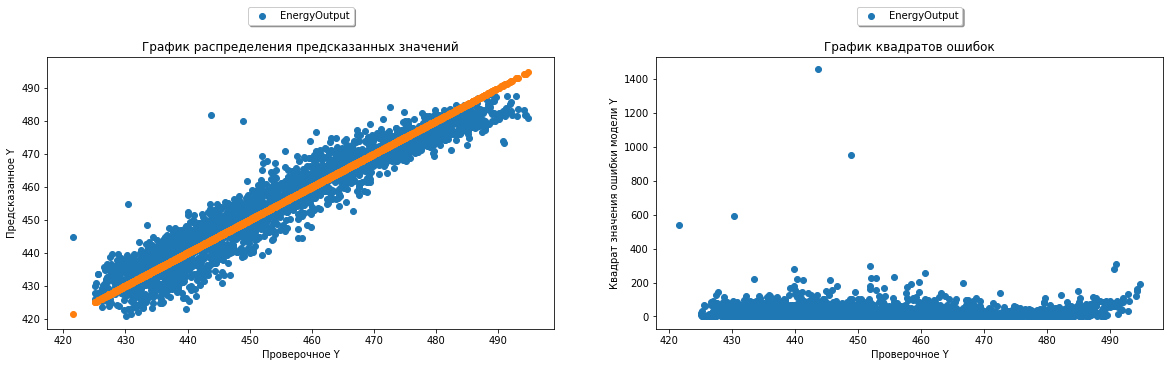

In [58]:
# Графики на одном полотне
plt.figure(figsize=figsize(20,5))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test, y_pred_LinRegrMult, label="EnergyOutput")
plt.scatter(y_test, y_test)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)
plt.title(u'График распределения предсказанных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

# создать второе полотно 122: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test,  pow(abs(y_test - y_pred_LinRegrMult),2) , label="EnergyOutput" )
# линия границы диапазона
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)
plt.title(u'График квадратов ошибок');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Квадрат значения ошибки модели Y')

## 2.2. Диапазон применимости модели

На основе данных графика соотношения ошибок установим диапазон применимости модели множественной линейной регрессии.

Диапазон для значений целевой переменной от 425 до 490. Сформируем новую выборку из данных входящий в этот диапазон. Работа с всеми следующими моделями будет осуществляться на выбранном диапазон данных.

In [82]:
# получить все строки удовлетворяющие условию
data_new =  data [ ( data ['EnergyOutput']  < 495 ) ]

In [83]:
# получить все строки удовлетворяющие условию
data_new =  data_new [ ( data_new ['EnergyOutput']  > 425 ) ]

In [84]:
print "valid_size " + str(valid_size)
print "rand_seed " + str(rand_seed)
x_train_diap, x_test_diap, y_train_diap, y_test_diap =  train_test_split(
    data_new[features], data_new[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов в диапазоне применимотси: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train_diap), len(x_test_diap),
    len(y_train_diap), len(y_test_diap), 
    len(x_train_diap)+len(x_test_diap), len(y_train_diap)+len(y_test_diap),
)

valid_size 0.3
rand_seed 8
Кол-во элементов в диапазоне применимотси: 
  x_train: 6692, y_train 2869 
  x_test:  6692, y_test  2869 
  total x: 9561, total y 9561 


# 2.3. Модель множественной линейной регрессии на диапазоне применимости

Обучим модель на новой выборке и сравним результы метрик.

In [85]:
model_LinRegrMult2 = linear_model.LinearRegression()

model_LinRegrMult2.fit(x_train_diap, y_train_diap)

y_pred_LinRegrMult2 = model_LinRegrMult2.predict(x_test_diap)

In [87]:
print "Множественная линейная регрессия. Усеченный диапазон."
print "model_LinRegrMult (x1, x2) =\n   {:,.3f}*{:} + {:,.3f}*{:} + {:,.3f}\n".format(
    model_LinRegrMult.coef_[0][0], features[0],
    model_LinRegrMult.coef_[0][1], features[1],
    model_LinRegrMult.intercept_[0])


print "Множественная линейная регрессия. Полный диапазон."
print "model_LinRegrMult2 (x1, x2) =\n   {:,.3f}*{:} + {:,.3f}*{:} + {:,.3f}\n".format(
    model_LinRegrMult2.coef_[0][0], features[0],
    model_LinRegrMult2.coef_[0][1], features[1],
    model_LinRegrMult2.intercept_[0])

mae_LinRegrMult2 = metrics.mean_absolute_error(y_test_diap, y_pred_LinRegrMult2)
r2_LinRegrMult2  = metrics.r2_score           (y_test_diap, y_pred_LinRegrMult2)

print "MAE - средняя абсолютная ошибка: {:>7,.0f} Усеченный диап. | {:>7,.0f} Полный диап.".format( mae_LinRegrMult2, mae_LinRegrMult)
print "R2 - коэфф. детерминации:        {:>7,.3f} Усеченный диап. | {:>7,.3f} Полный диап.".format       ( r2_LinRegrMult2 , r2_LinRegrMult)

Множественная линейная регрессия. Усеченный диапазон.
model_LinRegrMult (x1, x2) =
   -1.696*Temperature + -0.328*Vacuum + 505.521

Множественная линейная регрессия. Полный диапазон.
model_LinRegrMult2 (x1, x2) =
   -1.705*Temperature + -0.330*Vacuum + 505.738

MAE - средняя абсолютная ошибка:       4 Усеченный диап. |       4 Полный диап.
R2 - коэфф. детерминации:          0.919 Усеченный диап. |   0.918 Полный диап.


Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435 Y')

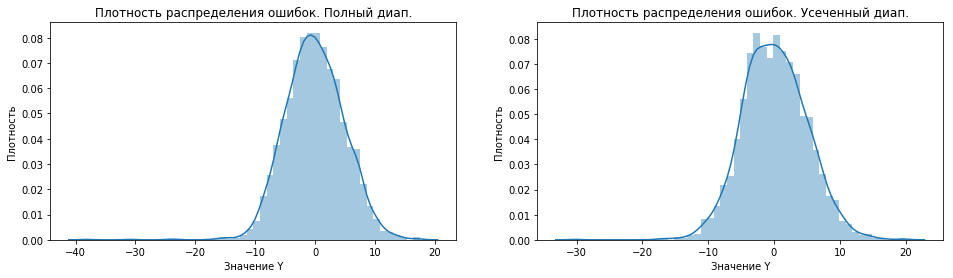

In [89]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot((y_test - y_pred_LinRegrMult))
# линия границы диапазона
plt.plot(
    [0, 0],
    [0, 1.2 * pow(10,-6)],    '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок. Полный диап.');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение Y')

plt.subplot(122)
sns.distplot((y_test_diap - y_pred_LinRegrMult2))
plt.plot(
    [0, 0],
    [0, 1.45 * pow(10,-6)],   '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок. Усеченный диап.');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение Y')

Text(0,0.5,u'\u043a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u041e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

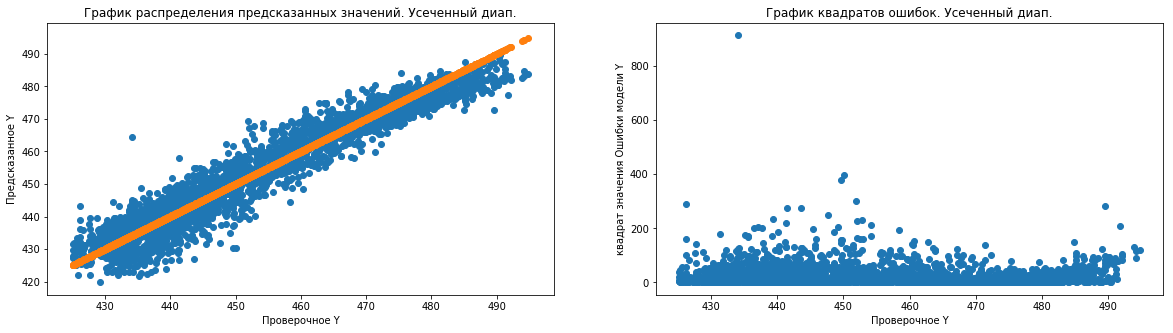

In [91]:
plt.figure(figsize=figsize(20,5))

plt.subplot(121)
plt.scatter(y_test_diap, y_pred_LinRegrMult2)
plt.scatter(y_test_diap, y_test_diap)
plt.title(u'График распределения предсказанных значений. Усеченный диап.');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

plt.subplot(122)
plt.scatter(y_test_diap,  pow(abs(y_test_diap - y_pred_LinRegrMult2),2) )
plt.title(u'График квадратов ошибок. Усеченный диап.');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'квадрат значения Ошибки модели Y')

# 2.4. Дерево регрессии


Глубина дерева=1, R2_кросс.вал. 0.717, R2 на проверочной части = 0.720
[0.71969038 0.72360705 0.72525015 0.70892975 0.70716907]

Глубина дерева=2, R2_кросс.вал. 0.858, R2 на проверочной части = 0.861
[0.86215895 0.85566427 0.86205183 0.8591819  0.84879233]

Глубина дерева=3, R2_кросс.вал. 0.906, R2 на проверочной части = 0.911
[0.91097213 0.90411349 0.90674853 0.90587017 0.90026779]

Глубина дерева=4, R2_кросс.вал. 0.922, R2 на проверочной части = 0.928
[0.92787571 0.92140881 0.92178414 0.92162511 0.91829531]

Глубина дерева=5, R2_кросс.вал. 0.928, R2 на проверочной части = 0.933
[0.93472962 0.92822696 0.92395969 0.92581675 0.92550781]

Глубина дерева=6, R2_кросс.вал. 0.927, R2 на проверочной части = 0.936
[0.93626018 0.9306435  0.92616344 0.92756627 0.91527177]

Глубина дерева=7, R2_кросс.вал. 0.929, R2 на проверочной части = 0.938
[0.93903142 0.93075886 0.9289036  0.92927671 0.91841773]

Глубина дерева=8, R2_кросс.вал. 0.929, R2 на проверочной части = 0.940
[0.94080567 0.93288114 0.

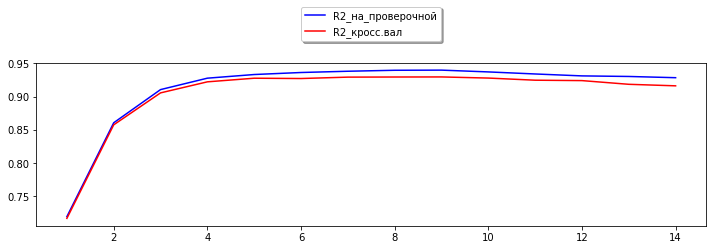

In [93]:
max_depth = 15
tree_seed=1
listR2_Cross = []
listR2_Test = []

for i in range (1,max_depth):
    # создать модель дерева регрессии с очередным значением глубины
    dtRegr = tree.DecisionTreeRegressor(max_depth=i, random_state=tree_seed )
    
    # обучить модель дерева регрессии на тренировочной части выборки
    dtRegr.fit(x_train_diap, y_train_diap)
    
    # получить предсказание модели на проверочной части выборки
    y_dtRegr = dtRegr.predict(x_test_diap)
    
    # получить оценку R2 на тренировочной подвыборке, разделенной на cv= 5 частей
    scores_cross = cross_val_score(dtRegr, x_train_diap, y_train_diap, cv=5, scoring='r2')
    
    # получить оценку R2 на проверочной подвыборке
    scores_test =  metrics.r2_score(y_test_diap, y_dtRegr)
    
    # сохранение результата
    listR2_Cross.append( scores_cross.mean() )
    listR2_Test.append( scores_test.mean() )
    
   
    print ""
    print "Глубина дерева={}, R2_кросс.вал. {:.3}, R2 на проверочной части = {:.3f}".format(
        dtRegr.max_depth, 
        listR2_Cross[i-1],
        listR2_Test[i-1]
    )
    print scores_cross
        
print "Максимальный R2= R2_кросс.вал. {:.3}, R2 на проверочной части = {:.3f}".format(

        max(listR2_Cross),
        max(listR2_Test)
    )

plt.figure(figsize(12, 3))
plt.plot( np.arange(1, max_depth, step=1) , listR2_Test ,  label= u"R2_на_проверочной", c="b")
plt.plot( np.arange(1, max_depth, step=1) , listR2_Cross,  label= u"R2_кросс.вал", c="r")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)

Значение оптимальной глубины дерева регрессии принимаем равной 8. Приступим к оценке полученной модели.

In [111]:
opt_depth= 8
treeRegr_d8 = tree.DecisionTreeRegressor(max_depth=opt_depth)
treeRegr_d8.fit(x_train_diap, y_train_diap)

# Получить предсказанные значения на проверочном наборе
y_treeRegr_d8_diap = treeRegr_d8.predict(x_test_diap)

In [112]:
y_treeRegr_d8_diap

array([444.86216216, 466.83572864, 439.95384615, ..., 451.45837209,
       432.59294118, 462.94775362])

In [113]:
print "Дерево решений. Регрессия. Усеченный диапазон."
mae_tree = metrics.mean_absolute_error(y_test_diap, y_treeRegr_d8_diap)
r2_tree  = metrics.r2_score          (y_test_diap, y_treeRegr_d8_diap)

print "MAE - средняя абсолютная ошибка: {:>7,.0f} дерево регр. | {:>7,.0f} лин. регр.".format( mae_tree, mae_LinRegrMult2)
print "R2  - коэфф. детерминации:       {:>7,.3f} дерево регр. | {:>7,.3f} лин. регр.".format( r2_tree , r2_LinRegrMult2 )

Дерево решений. Регрессия. Усеченный диапазон.
MAE - средняя абсолютная ошибка:       3 дерево регр. |       4 лин. регр.
R2  - коэфф. детерминации:         0.940 дерево регр. |   0.919 лин. регр.


Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

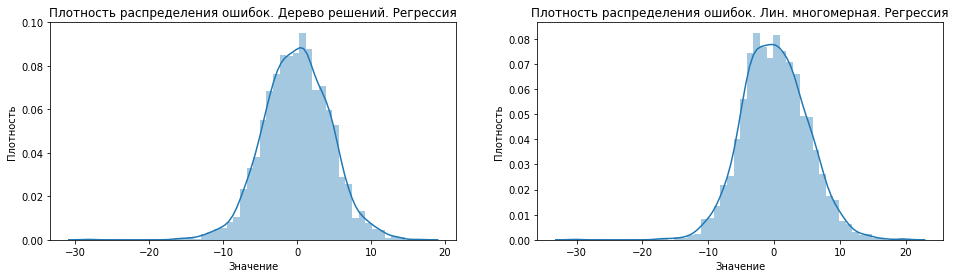

In [101]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot((y_test_diap - y_treeRegr_d5_diap.reshape(-1,1)))
plt.plot(
    [0, 0],
    [0, 1.6 * pow(10,-6)],  '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок. Дерево решений. Регрессия');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

plt.subplot(122)
sns.distplot((y_test_diap - y_pred_LinRegrMult2))
plt.plot(
    [0, 0],
    [0, 1.5 * pow(10,-6)],  '--', lw=2, c='r')
plt.title(u'Плотность распределения ошибок. Лин. многомерная. Регрессия');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

Text(0,0.5,u'\u043a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u043e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

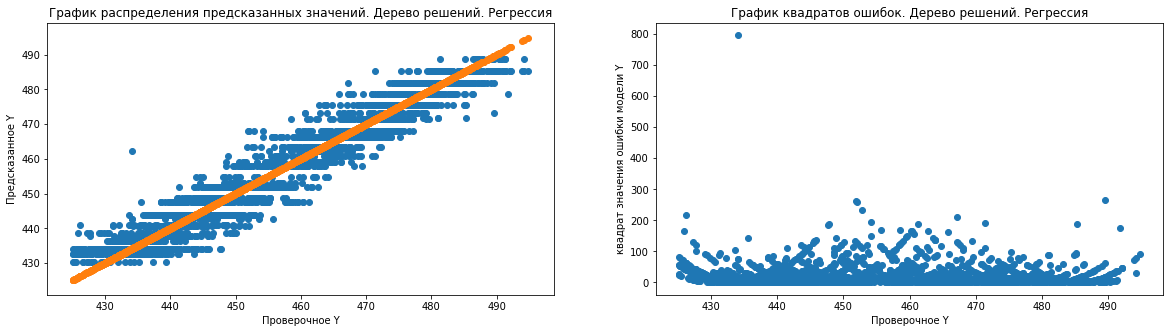

In [103]:
# Графики на одном полотне

plt.figure(figsize=figsize(20,5))
plt.subplot(121)
plt.scatter(y_test_diap, y_treeRegr_d5_diap)
plt.scatter(y_test_diap, y_test_diap)
plt.title(u'График распределения предсказанных значений. Дерево решений. Регрессия');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Предсказанное Y')

plt.subplot(122)
plt.scatter(y_test_diap,  pow(abs(y_test_diap - y_treeRegr_d5_diap.reshape(-1,1)),2) )
plt.title(u'График квадратов ошибок. Дерево решений. Регрессия');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'квадрат значения ошибки модели Y')

In [114]:
# сохранение структуры дерева в промежуточном формате *.dot
export_graphviz(treeRegr_d8, out_file='treeRegr_d8.dot')

In [116]:
# создание графического изображения структуры дерева решений при помощи ПО "Graphviz"
# путь(абсолютный или относительный) к внешнему исполняемому файлу \graphviz-2.38\release\bin\dot.exe
!C:\Users\latyg\Desktop\graphviz-2.38\release\bin\dot.exe -Tpng treeRegr_d8.dot -o treeRegr_d8.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.881212 to fit


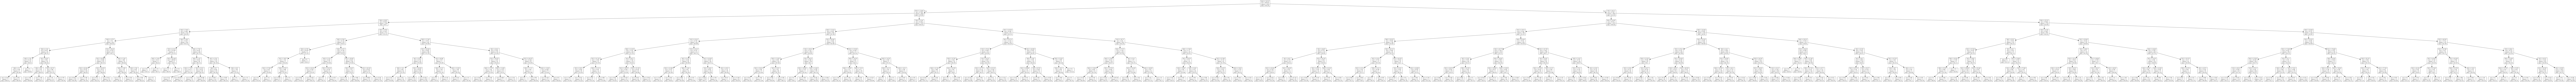

In [117]:
# показать изображение
from IPython.display import Image
Image(filename='treeRegr_d8.png')

# Выводы

Точность модели дерева регрессии выше, чем точность множественной линейной регрессии.

Множественная линейная регрессия. Усеченный диапазон.
model_LinRegrMult (x1, x2) = -1.696*Temperature + -0.328*Vacuum + 505.521

Множественная линейная регрессия. Полный диапазон.
model_LinRegrMult2 (x1, x2) = -1.705*Temperature + -0.330*Vacuum + 505.738

MAE - средняя абсолютная ошибка:       4 Усеченный диап. |       4 Полный диап.
R2 - коэфф. детерминации:          0.919 Усеченный диап. |   0.918 Полный диап.

Дерево решений. Регрессия. Усеченный диапазон.
MAE - средняя абсолютная ошибка:       3 дерево регр. |       4 лин. регр.
R2  - коэфф. детерминации:         0.940 дерево регр. |   0.919 лин. регр.